# LangGraph : Research Assistant with STORM

- Author: [Secludor](https://github.com/Secludor)
- Design: [LeeYuChul](https://github.com/LeeYuChul)
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

Research is often a labor-intensive task delegated to analysts, but AI holds tremendous potential to revolutionize this process. This tutorial explores **how to construct a customized AI-powered research and report generation workflow** using `LangGraph`, incorporating key concepts from Stanford's STORM framework.

### Why This Approach?
The STORM methodology has demonstrated significant improvements in research quality through two key innovations:
- Outline creation through querying similar topics enhances coverage.
- Multi-perspective conversation simulation increases reference usage and information density.

The translation is accurate but can be enhanced for better clarity and technical precision. Here's the reviewed version:

### Key Components

**Core Themes**
- Memory: State management and persistence across interactions.
- Human-in-the-loop: Interactive feedback and validation mechanisms.
- Controllability: Fine-grained control over agent workflows.

**Research Framework**
- Research Automation Objective: Building customized research processes tailored to user requirements.
- Source Management: Strategic selection and integration of research input sources.
- Planning Framework: Topic definition and AI analyst team assembly.

### Process Implementation

**Execution Flow**
- LLM Integration: Conducting comprehensive expert AI interviews.
- Parallel Processing: Simultaneous information gathering and interview execution.
- Output Synthesis: Integration of research findings into comprehensive reports.

**Technical Implementation**
- Environment Setup: Configuration of runtime environment and API authentication.
- Analyst Development: Human-supervised analyst creation and validation process.
- Interview Management: Systematic question generation and response collection.
- Parallel Processing: Implementation of Map-Reduce for interview parallelization.
- Report Generation: Structured composition of introductory and concluding sections.


AI has significant potential to support these research processes. However, research requires customization. Raw LLM outputs are often not suitable for real decision-making workflows.

A customized AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflow is a promising solution to address this issue.

![10-LangGraph-Research-Assitant-concept](./assets/10-LangGraph-Research-Assitant-concept.png)

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Utilities](#utilities)
- [Analysts Generation : Human in the Loop](#analysts-generation--human-in-the-loop)
- [Interview Execution](#interview-execution)
- [Report Writing](#report-writing)

### References

- [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag)
- [LangGraph `Send()`](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)
- [LangGraph - Multi-Agent](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#custom-multi-agent-workflow)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install -U langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain_core",
        "langchain_community",
        "langchain_openai",
        "tavily-python",
        "arxiv",
        "pymupdf",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "TAVILY_API_KEY": "",
        }
    )

# set the project name same as the title
set_env(
    {
        "LANGCHAIN_PROJECT": "LangGraph-Research-Assistant",
    }
)

Environment variables have been set successfully.


## Utilities

These are brief descriptions of the modules from `langchain-opentutorial` used for practice.

### `visualize_graph`
for visualizing graph structure

### `random_uuid` , `invoke_graph`
- `random_uuid` : for generating a random UUID (Universally Unique Identifier) and returns it as a string.
- `invoke_graph` : for streaming and displays the results of executing a CompiledStateGraph instance in a visually appealing format. 

### `TabilySearch`

This code defines a tool for performing search queries using the Tavily Search API. It includes input validation, formatting of search results, and the ability to customize search parameters.
**Methods** :
- `__init__` : Initializes the TavilySearch instance, setting up the API client and input parameters.
- `_run` : Implements the base tool's run method, calling the search method and returning results.
- `search` : Performs the actual search using the Tavily API, taking various optional parameters to customize the query. It formats the output based on user preferences.
- `get_search_context` : Retrieves relevant context based on a search query, returning a JSON string that includes search results formatted as specified.

## Analysts Generation : Human in the Loop
**Analyst Generation** : Create and review analysts using Human-In-The-Loop.

In [4]:
from langchain_openai import ChatOpenAI

# Initialize the model
llm = ChatOpenAI(model="gpt-4o")

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_opentutorial.graphs import visualize_graph


# Class defining analyst properties and metadata
class Analyst(BaseModel):
    # Primary affiliation information
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    # Name
    name: str = Field(description="Name of the analyst.")

    # Role
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    # Description of focus, concerns, and motives
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    # Property that returns analyst's personal information as a string
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# Collection of analysts
class Perspectives(BaseModel):
    # List of analysts
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

The following defines the state that tracks the collection of analysts generated through the Analyst class:

In [6]:
# State Definition
class GenerateAnalystsState(TypedDict):
    # Research topic
    topic: str
    # Maximum number of analysts to generate
    max_analysts: int
    # Human feedback
    human_analyst_feedback: str
    # List of analysts
    analysts: List[Analyst]

### Defining the Analyst Generation Node

Next, we will define the analyst generation node.

The code below implements the logic for generating various analysts based on the provided research topic. Each analyst has a unique role and affiliation, offering professional perspectives on the topic.

In [7]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage

# Analyst generation prompt
analyst_instructions = """You are tasked with creating a set of AI analyst personas. 

Follow these instructions carefully:
1. First, review the research topic:

{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide the creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and/or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# Analyst generation node
def create_analysts(state: GenerateAnalystsState):
    """Function to create analyst personas"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Apply structured output format to LLM
    structured_llm = llm.with_structured_output(Perspectives)

    # Construct system prompt for analyst creation
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # Call LLM to generate analyst personas
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    # Store generated list of analysts in state
    return {"analysts": analysts.analysts}


# User feedback node (can be left empty since it will update state)
def human_feedback(state: GenerateAnalystsState):
    """A checkpoint node for receiving user feedback"""
    pass


# Function to decide the next step in the workflow based on human feedback
def should_continue(state: GenerateAnalystsState):
    """Function to determine the next step in the workflow"""

    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

**Explanation of Code Components**

- **Analyst Instructions**: A prompt that guides the LLM in creating AI analyst personas based on a specified research topic and any provided feedback.

- **create_analysts Function**: This function is responsible for generating a set of analysts based on the current state, which includes the research topic, maximum number of analysts, and any human feedback.

- **human_feedback Function**: A placeholder function that can be expanded to handle user feedback.

- **should_continue Function**: This function evaluates whether there is human feedback available and determines whether to proceed with creating analysts or end the process. 

This structure allows for a dynamic approach to generating tailored analyst personas that can provide diverse insights into a given research topic.

### Building the Analyst Generation Graph

Now we'll create the analyst generation graph that orchestrates the research workflow.

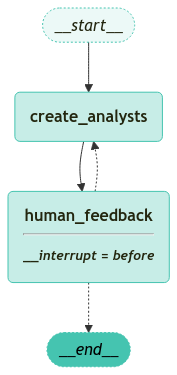

In [8]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Create graph
builder = StateGraph(GenerateAnalystsState)

# Add nodes
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# Connect edges
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# Add conditional edge: return to analyst creation node if human feedback exists
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# Create memory
memory = MemorySaver()

# Compile graph (set breakpoints)
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Visualize graph
visualize_graph(graph)

**Graph Components**

- **Nodes**
    - `create_analysts`: Generates analyst personas based on the research topic
    - `human_feedback`: Checkpoint for receiving user input and feedback

- **Edges**
    - Initial flow from START to analyst creation
    - Connection from analyst creation to human feedback
    - Conditional path back to analyst creation based on feedback

- **Features**
    - Memory persistence using `MemorySaver`
    - Breakpoints before human feedback collection
    - Visual representation of workflow through `visualize_graph`

This graph structure enables an iterative research process with human oversight and feedback integration.

### Running the Analyst Generation Graph
Here's how to execute and manage the analyst generation workflow:

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import random_uuid, invoke_graph


# Configure graph execution settings


config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)


# Set number of analysts


max_analysts = 3


# Define research topic


topic = "What are the differences between Modular RAG and Naive RAG, and what are the benefits of using it at the production level"


# Configure input parameters


inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}


# Execute graph


invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech Research Institute' name='Dr. Emily Carter' role='Senior Research Scientist' description='Dr. Carter focuses on the architectural differences between Modular RAG and Naive RAG, with an emphasis on understanding how modularity impacts flexibility and scalability in AI systems.'
affiliation='AI Development Group' name='Michael Nguyen' role='Lead AI Engineer' description="Michael's primary concern is the practical benefits of implementing Modular RAG at the production level, particularly in terms of efficiency, resource management, and ease of integration."
affiliation='University of Advanced Computing' name='Prof. Laura Chen' role='Professor of Computer Science' description='Prof. Chen studies the theoretical implications of using Modular versus Naive RAG, analyzing the long-term benefits and potential challenges faced in deploying these systems in real-world scenarios.'

🔄 Node: __interrupt__

When `__interrupt__` is displayed, the system is ready to receive human feedback. At this point, you can retrieve the current state and provide feedback to guide the analyst generation process.

In [10]:
# Get current graph state
state = graph.get_state(config)

# Check next node
print(state.next)

('human_feedback',)


To inject human feedback into the graph, we use the `update_state` method with the following key components:

In [11]:
# Update graph state with human feedback
graph.update_state(
    config,
    {
        "human_analyst_feedback": "Add in someone named Teddy Lee from a startup to add an entrepreneur perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '77b5f1cc-b454-4a81-9d4d-32949e109a66',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9c73-576d-6e75-8002-4bdd66b12cff'}}

**Key Parameters**
- `config` : Configuration object containing graph settings
- `human_analyst_feedback` : Key for storing feedback content
- `as_node` : Specifies the node that will process the feedback

**[Note]** : Assigning `None` as input triggers the graph to continue its execution from the last checkpoint. This is particularly useful when you want to resume processing after providing human feedback.

(Continue) To resume the graph execution after the `__interrupt__` :

In [12]:
# Continue execution
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='AI Technology Research Institute' name='Dr. Emily Zhang' role='AI Researcher' description='Dr. Zhang focuses on the technical distinctions between Modular RAG and Naive RAG, analyzing their architectural differences, computational efficiencies, and adaptability in various AI applications. Her interest lies in understanding how these models can be optimized for better performance and scalability.'
affiliation='Tech Innovations Startup' name='Teddy Lee' role='Entrepreneur' description='Teddy Lee provides insights into the practical implications and business benefits of implementing Modular RAG over Naive RAG at the production level. He evaluates cost-efficiency, scalability, and the potential for innovative applications in startup environments, aiming to leverage cutting-edge technology for competitive advantage.'
affiliation='Enterprise Solutions Inc.' name='Sophia Martinez' role='Industry Analyst

When `__interrupt__` appears again, you have two options: 

- Option 1: Provide Additional Feedback
    - You can provide more feedback to further refine the analyst personas using the same method as before
- Option 2: Complete the Process

To finish the analyst generation process without additional feedback:

In [13]:
# Set feedback input to None to indicate completion
human_feedback_input = None

# Update graph state with no feedback
graph.update_state(
    config, {"human_analyst_feedback": human_feedback_input}, as_node="human_feedback"
)

{'configurable': {'thread_id': '77b5f1cc-b454-4a81-9d4d-32949e109a66',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9c73-86e0-67db-8004-1b34f460d397'}}

In [14]:
# Continue final execution
invoke_graph(graph, None, config)

**Displaying Final Results**

Get and display the final results from the graph:

In [15]:
# Get final state
final_state = graph.get_state(config)

# Get generated analysts
analysts = final_state.values.get("analysts")

# Print analyst count
print(
    f"Number of analysts generated: {len(analysts)}",
    end="\n================================\n",
)

# Print each analyst's persona
for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

# Get next node state (empty tuple indicates completion)
print(final_state.next)

Number of analysts generated: 3
Name: Dr. Emily Zhang
Role: AI Researcher
Affiliation: AI Technology Research Institute
Description: Dr. Zhang focuses on the technical distinctions between Modular RAG and Naive RAG, analyzing their architectural differences, computational efficiencies, and adaptability in various AI applications. Her interest lies in understanding how these models can be optimized for better performance and scalability.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Teddy Lee
Role: Entrepreneur
Affiliation: Tech Innovations Startup
Description: Teddy Lee provides insights into the practical implications and business benefits of implementing Modular RAG over Naive RAG at the production level. He evaluates cost-efficiency, scalability, and the potential for innovative applications in startup environments, aiming to leverage cutting-edge technology for competitive advantage.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Sophia Ma

**Key Components**
- `final_state`: Contains the final state of the graph execution.
- `analysts`: List of generated analyst personas.
- `final_state.next`: Empty tuple indicating workflow completion.

The output will display each analyst's complete persona information, including their name, role, affiliation, and description, followed by a separator line. The empty tuple printed at the end confirms that the graph execution has completed successfully.

## Interview Execution

### Define Classes and `question_generation` Node
Let's implement the interview execution components with proper state management and `question_generation` Node:

In [16]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """State management for interview process"""

    max_num_turns: int
    context: Annotated[list, operator.add]  # Context list containing source documents
    analyst: Analyst
    interview: str  # String storing interview content
    sections: list  # List of report sections


class SearchQuery(BaseModel):
    """Data class for search queries"""

    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
def generate_question(state: InterviewState):
    """Node for generating interview questions"""

    # System prompt for question generation
    question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

    Your goal is boil down to interesting and specific insights related to your topic.

    1. Interesting: Insights that people will find surprising or non-obvious.
            
    2. Specific: Insights that avoid generalities and include specific examples from the expert.

    Here is your topic of focus and set of goals: {goals}
            
    Begin by introducing yourself using a name that fits your persona, and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.
            
    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

    # Extract state components
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question using LLM
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Return updated messages
    return {"messages": [question]}

**State Management**
- `InterviewState` tracks conversation turns, context, and interview content.
- Annotated context list allows for document accumulation.
- Maintains analyst persona and report sections.

**Question Generation**
- Structured system prompt for consistent interviewing style.
- Persona-aware questioning based on analyst goals.
- Progressive refinement of topic understanding.
- Clear interview conclusion mechanism.

The code provides a robust foundation for conducting structured interviews while maintaining conversation state and context.

### Defining Research Tools

Experts collect information in parallel from multiple sources to answer questions.

They can utilize various tools such as web document scraping, VectorDB, web search, and Wikipedia search.

We'll focus on two main tools: **`Tavily`** for web search and **`ArxivRetriever`** for academic papers.

`Tavily Search`
- Real-time web search capabilities
- Configurable result count and content depth
- Structured output formatting
- Raw content inclusion option

In [18]:
from langchain_opentutorial.tools.tavily import TavilySearch

# Initialize TavilySearch with configuration


tavily_search = TavilySearch(max_results=3)

`ArxivRetriever`
- Access to academic papers and research
- Full document retrieval
- Comprehensive metadata access
- Customizable document load limits

In [19]:
from langchain_community.retrievers import ArxivRetriever

# Initialize ArxivRetriever with configuration
arxiv_retriever = ArxivRetriever(
    load_max_docs=3, load_all_available_meta=True, get_full_documents=True
)

# Execute arxiv search and print results
arxiv_search_results = arxiv_retriever.invoke("Modular RAG vs Naive RAG")
print(arxiv_search_results)

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

In [20]:
# metadata of Arxiv
arxiv_search_results[0].metadata

{'Published': '2024-07-26',
 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks',
 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang',
 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a highly reconfigurabl

In [21]:
# content of Arxiv
print(arxiv_search_results[0].page_content)

1
Modular RAG: Transforming RAG Systems into
LEGO-like Reconfigurable Frameworks
Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang
Abstract—Retrieval-augmented
Generation
(RAG)
has
markedly enhanced the capabilities of Large Language Models
(LLMs) in tackling knowledge-intensive tasks. The increasing
demands of application scenarios have driven the evolution
of RAG, leading to the integration of advanced retrievers,
LLMs and other complementary technologies, which in turn
has amplified the intricacy of RAG systems. However, the rapid
advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process
of “retrieve-then-generate”. In this context, this paper examines
the limitations of the existing RAG paradigm and introduces
the modular RAG framework. By decomposing complex RAG
systems into independent modules and specialized operators, it
facilitates a highly reconfigurable framework. Modular RAG
transcends the traditional linear architect

 format and display Arxiv search results in a structured XML-like format:

In [22]:
# 문서 검색 결과를 포맷팅
formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in arxiv_search_results
    ]
)

In [23]:
print(formatted_search_docs)

<Document source="http://arxiv.org/abs/2407.21059v1" date="2024-07-26" authors="Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang"/>
<Title>
Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks
</Title>

<Summary>
Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities
of Large Language Models (LLMs) in tackling knowledge-intensive tasks. The
increasing demands of application scenarios have driven the evolution of RAG,
leading to the integration of advanced retrievers, LLMs and other complementary
technologies, which in turn has amplified the intricacy of RAG systems.
However, the rapid advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process of
"retrieve-then-generate". In this context, this paper examines the limitations
of the existing RAG paradigm and introduces the modular RAG framework. By
decomposing complex RAG systems into independent modules and specialized
operators, it fa

### Defining Search Tool Nodes

The code implements two main search tool nodes for gathering research information: web search via `Tavily` and academic paper search via `ArXiv`. Here's a breakdown of the key components:

In [24]:
from langchain_core.messages import SystemMessage

# Search query instruction
search_instructions = SystemMessage(
    content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""
)


def search_web(state: InterviewState):
    """Performs web search using Tavily"""

    # Generate search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # Execute search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format results - handle both string and dict responses
    if isinstance(search_docs, list):
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

    return {"context": [formatted_search_docs]}


def search_arxiv(state: InterviewState):
    """Performs academic paper search using ArXiv"""

    # Generate search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    try:
        # Execute search
        arxiv_search_results = arxiv_retriever.invoke(
            search_query.search_query,
            load_max_docs=2,
            load_all_available_meta=True,
            get_full_documents=True,
        )

        # Format results
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
                for doc in arxiv_search_results
            ]
        )

        return {"context": [formatted_search_docs]}
    except Exception as e:
        print(f"ArXiv search error: {str(e)}")
        return {"context": ["<Error>Failed to retrieve ArXiv search results.</Error>"]}

**Key Features**
- Query Generation: Uses LLM to create structured search queries from conversation context
- Error Handling: Robust error management for ArXiv searches
- Result Formatting: Consistent XML-style formatting for both web and academic results
- Metadata Integration: Comprehensive metadata inclusion for academic papers
- State Management: Maintains conversation context through InterviewState

### Define `generate_answer`, `save_interview`, `route_messages`, `write_section` Nodes

- The `generate_answer` node is responsible for creating expert responses during the interview process.

In [25]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


def generate_answer(state: InterviewState):
    """Generates expert responses to analyst questions"""

    # Get analyst and messages from state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Generate answer for the question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Name the message as expert response
    answer.name = "expert"

    # Add message to state
    return {"messages": [answer]}

- `save_interview`

In [26]:
def save_interview(state: InterviewState):
    """Saves the interview content"""

    # Get messages from state
    messages = state["messages"]

    # Convert interview to string
    interview = get_buffer_string(messages)

    # Store under interview key
    return {"interview": interview}

### Define `generate_answer`, `save_interview`, `route_messages`, `write_section` Nodes
- `route_messages`

In [27]:
def route_messages(state: InterviewState, name: str = "expert"):
    """Routes between questions and answers in the conversation"""

    # Get messages from state
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Count expert responses
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End interview if maximum turns reached
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router runs after each question-answer pair
    # Get the last question to check for conversation end signal
    last_question = messages[-2]

    # Check for conversation end signal
    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"

- The `write_section` function and its associated instructions implement a structured report generation system.

In [28]:
section_writer_instructions = """You are an expert technical writer. 

Your task is to create a detailed and comprehensive section of a report, thoroughly analyzing a set of source documents.
This involves extracting key insights, elaborating on relevant points, and providing in-depth explanations to ensure clarity and understanding. Your writing should include necessary context, supporting evidence, and examples to enhance the reader's comprehension. Maintain a logical and well-organized structure, ensuring that all critical aspects are covered in detail and presented in a professional tone.

Please follow these instructions:
1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Comprehensive analysis (### header)
d. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. For the Comprehensive analysis section:
- Provide a detailed examination of the information from the source documents.
- Break down complex ideas into digestible segments, ensuring a logical flow of ideas.
- Use sub-sections where necessary to cover multiple perspectives or dimensions of the analysis.
- Support your analysis with data, direct quotes, and examples from the source documents.
- Clearly explain the relevance of each point to the overall focus of the report.
- Use bullet points or numbered lists for clarity when presenting multiple related ideas.
- Ensure the tone remains professional and objective, avoiding bias or unsupported opinions.
- Aim for at least 800 words to ensure the analysis is thorough.

7. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

8. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
9. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


def write_section(state: InterviewState):
    """Generates a structured report section based on interview content"""

    # Get context and analyst from state
    context = state["context"]
    analyst = state["analyst"]

    # Define system prompt for section writing
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [
            SystemMessage(content=system_message),
            HumanMessage(content=f"Use this source to write your section: {context}"),
        ]
    )

    # Add section to state
    return {"sections": [section.content]}

### Building the Interview Graph
Here's how to create and configure the interview execution graph:

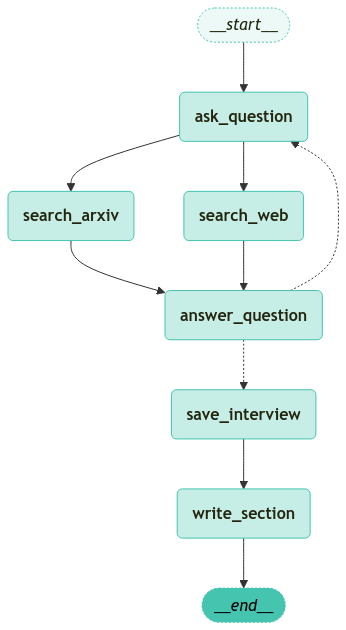

In [29]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Add nodes and edges
interview_builder = StateGraph(InterviewState)

# Define nodes
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Configure flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Create interview graph with memory
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# Visualize the graph
visualize_graph(interview_graph)

**Graph Structure**

The interview process follows this flow:
1. Question Generation
2. Parallel Search (Web and ArXiv)
3. Answer Generation
4. Conditional Routing
5. Interview Saving
6. Section Writing

**Key Components**
- State Management: Uses InterviewState for tracking
- Memory Persistence: Implements MemorySaver
- Conditional Logic: Routes between questions and interview completion
- Parallel Processing: Conducts simultaneous web and academic searches

Note: Ensure the langgraph module is installed before running this code.

### Executing the Interview Graph
Here's how to execute the graph and display the results:

In [30]:
# Select first analyst from the list
analysts[0]

Analyst(affiliation='AI Technology Research Institute', name='Dr. Emily Zhang', role='AI Researcher', description='Dr. Zhang focuses on the technical distinctions between Modular RAG and Naive RAG, analyzing their architectural differences, computational efficiencies, and adaptability in various AI applications. Her interest lies in understanding how these models can be optimized for better performance and scalability.')

In [31]:
from IPython.display import Markdown

# Set research topic
topic = "What are the differences between Modular RAG and Naive RAG, and what are the benefits of using it at production level"

# Create initial interview message
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# Configure thread ID
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# Execute graph
invoke_graph(
    interview_graph,
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 5},
    config,
)


🔄 Node: ask_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, my name is Alex Turner, and I'm an analyst interested in learning about the fascinating world of AI architectures. Dr. Zhang, could you explain the fundamental differences between Modular RAG and Naive RAG, particularly in terms of their architecture and how these differences impact their performance?

🔄 Node: search_web 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document href="https://www.superteams.ai/blog/how-to-implement-naive-rag-advanced-rag-and-modular-rag"/>
Naive RAG is a paradigm that combines information retrieval with natural language generation to produce responses to queries or prompts. In Naive RAG, retrieval is typically performed using retrieval models that rank the indexed data based on its relevance to the input query. These models generate text based on the input query and the retrieved context

Display completed interview section in markdown

In [32]:
Markdown(interview_graph.get_state(config).values["sections"][0])

## Exploring the Architectural Advancements in Modular and Naive RAG

### Summary

Retrieval-Augmented Generation (RAG) is a promising technique that enhances the capabilities of large language models (LLMs) by incorporating external data through retrieval mechanisms. This report focuses on the architectural distinctions between Modular RAG and Naive RAG, highlighting their respective computational efficiencies and adaptability in various AI applications. The evolution from Naive RAG to Modular RAG marks a significant shift in how LLMs handle knowledge-intensive tasks, prompting a need for a deeper understanding of their optimization for performance and scalability.

Naive RAG, foundational in its approach, integrates information retrieval with language generation to produce contextually relevant responses. However, it often struggles with inflexibility and inefficiencies when dealing with diverse datasets, primarily due to its reliance on straightforward similarity calculations for retrieval. In contrast, Modular RAG introduces a reconfigurable framework by decomposing complex RAG systems into independent modules, facilitating more sophisticated routing, scheduling, and fusion mechanisms. This modularity allows for more precise control and customization, making Modular RAG systems more adaptable to specific application needs.

The novelty of insights gathered from recent literature reveals a trend towards modular frameworks to overcome the limitations of traditional RAG systems. Notably, the theory of token-level harmonization in RAG presents a novel approach to balancing the benefits and detriments of retrieval, offering a theoretical foundation that could enhance the precision of LLM responses.

Key source documents include:
1. [1] http://arxiv.org/abs/2406.00944v2
2. [2] http://arxiv.org/abs/2407.21059v1
3. [3] https://www.superteams.ai/blog/how-to-implement-naive-rag-advanced-rag-and-modular-rag
4. [4] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/
5. [5] https://zilliz.com/blog/advancing-llms-native-advanced-modular-rag-approaches

### Comprehensive Analysis

The evolution of Retrieval-Augmented Generation (RAG) systems has led to significant advancements in how large language models (LLMs) integrate external information to enhance their generative capabilities. This section delves into the architectural and operational differences between Naive RAG and Modular RAG, emphasizing their impact on computational efficiency and adaptability.

#### Naive RAG: Foundations and Limitations

Naive RAG represents the initial phase of RAG systems, primarily characterized by its "retrieve-then-generate" approach. This model combines document retrieval with language model generation, aiming to produce coherent and contextually relevant responses. However, several challenges undermine its effectiveness:

- **Shallow Understanding of Queries**: Naive RAG relies heavily on semantic similarity for retrieval, which can result in inadequate exploration of the query-document relationship. This limitation often leads to a failure in capturing nuanced query intents, affecting the accuracy of the generated responses [2].
  
- **Retrieval Redundancy and Noise**: The process of feeding all retrieved chunks into LLMs can introduce excessive noise, potentially misleading the model and increasing the risk of generating hallucinated responses. This redundancy highlights the need for more refined retrieval mechanisms [5].

- **Inflexibility**: The rigid architecture of Naive RAG restricts its adaptability to diverse and dynamic datasets, making it less suitable for specialized tasks or industries [4].

#### Modular RAG: A Reconfigurable Framework

Modular RAG addresses these limitations by introducing a highly reconfigurable framework that decomposes RAG systems into independent modules and specialized operators. This modular approach offers several advantages:

- **Advanced Design**: By integrating routing, scheduling, and fusion mechanisms, Modular RAG transcends the traditional linear architecture, allowing for more sophisticated data handling and processing [2].

- **Customization and Scalability**: The modularity of the system enables organizations to tailor RAG systems to specific application needs, enhancing relevance, response times, and customer satisfaction. This adaptability is crucial for scaling RAG systems across various domains [4].

- **Enhanced Retrieval and Generation**: The modular framework supports the inclusion of advanced retrievers and complementary technologies, improving the overall performance of RAG systems in handling complex queries and variable data [3].

#### Token-Level Harmonization Theory

A significant theoretical advancement in RAG systems is the introduction of a token-level harmonization theory. This approach models RAG as a fusion between the distribution of LLM knowledge and retrieved texts. It formalizes the trade-off between the value of external knowledge (benefit) and its potential to mislead LLMs (detriment) in next token prediction. This theoretical framework allows for a more explainable and quantifiable comparison of benefits and detriments, facilitating a balanced integration of external data [1].

#### Implications for AI Applications

The transition from Naive to Modular RAG represents a paradigm shift in how LLMs are utilized in AI applications. Modular RAG's adaptability and efficiency make it a preferable choice for tasks requiring high scalability and specialization. The ongoing research into token-level harmonization further enhances the precision and reliability of RAG systems, paving the way for more robust and contextually aware AI solutions.

### Sources
[1] http://arxiv.org/abs/2406.00944v2  
[2] http://arxiv.org/abs/2407.21059v1  
[3] https://www.superteams.ai/blog/how-to-implement-naive-rag-advanced-rag-and-modular-rag  
[4] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[5] https://zilliz.com/blog/advancing-llms-native-advanced-modular-rag-approaches  

In [33]:
print(interview_graph.get_state(config).values["sections"][0])

## Exploring the Architectural Advancements in Modular and Naive RAG

### Summary

Retrieval-Augmented Generation (RAG) is a promising technique that enhances the capabilities of large language models (LLMs) by incorporating external data through retrieval mechanisms. This report focuses on the architectural distinctions between Modular RAG and Naive RAG, highlighting their respective computational efficiencies and adaptability in various AI applications. The evolution from Naive RAG to Modular RAG marks a significant shift in how LLMs handle knowledge-intensive tasks, prompting a need for a deeper understanding of their optimization for performance and scalability.

Naive RAG, foundational in its approach, integrates information retrieval with language generation to produce contextually relevant responses. However, it often struggles with inflexibility and inefficiencies when dealing with diverse datasets, primarily due to its reliance on straightforward similarity calculations for re

### Parallel Interviewing by `map-reduce`
Here's how to implement parallel interviews using map-reduce in LangGraph:

In [34]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class ResearchGraphState(TypedDict):
    """State definition for research graph"""

    # Research topic
    topic: str
    # Maximum number of analysts
    max_analysts: int
    # Human analyst feedback
    human_analyst_feedback: str
    # List of questioning analysts
    analysts: List[Analyst]
    # List of sections containing Send() API keys
    sections: Annotated[list, operator.add]
    # Report components
    introduction: str
    content: str
    conclusion: str
    final_report: str

Let me explain how the `Send()` function is used in LangGraph for parallel interview execution:

**Reference**
- [LangGraph `Send()`](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)

In [35]:
from langgraph.constants import Send


def initiate_all_interviews(state: ResearchGraphState):
    """Initiates parallel interviews for all analysts"""

    # Check for human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")

    # Return to analyst creation if human feedback exists
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise, initiate parallel interviews using Send()
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]

## Report Writing

Next, we will define the guidelines for writing a report based on the interview content and define a function for report writing.

### Define Nodes
- Main Report Content

In [36]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.  
2. Carefully review and analyze the insights from each memo.  
3. Consolidate these insights into a detailed and comprehensive summary that integrates the central ideas from all the memos.  
4. Organize the key points from each memo into the appropriate sections provided below, ensuring that each section is logical and well-structured.  
5. Include all required sections in your report, using `### Section Name` as the header for each.  
6. Aim for approximately 250 words per section, providing in-depth explanations, context, and supporting details.  

**Sections to consider (including optional ones for greater depth):**

- **Background**: Theoretical foundations, key concepts, and preliminary information necessary to understand the methodology and results.
- **Related Work**: Overview of prior studies and how they compare or relate to the current research.
- **Problem Definition**: A formal and precise definition of the research question or problem the paper aims to address.
- **Methodology (or Methods)**: Detailed description of the methods, algorithms, models, data collection processes, or experimental setups used in the study.
- **Implementation Details**: Practical details of how the methods or models were implemented, including software frameworks, computational resources, or parameter settings.
- **Experiments**: Explanation of experimental protocols, datasets, evaluation metrics, procedures, and configurations employed to validate the methods.
- **Results**: Presentation of experimental outcomes, often with statistical tables, graphs, figures, or qualitative analyses.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


def write_report(state: ResearchGraphState):
    """Generates main report content from interview sections"""
    sections = state["sections"]
    topic = state["topic"]

    # Combine all sections
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Generate report from sections
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [
            SystemMessage(content=system_message),
            HumanMessage(content="Write a report based upon these memos."),
        ]
    )
    return {"content": report.content}

- Introduction Generation

In [37]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 200 words, crisply previewing (for introduction),  or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    """Creates report introduction"""
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions, HumanMessage(content="Write the report introduction")]
    )
    return {"introduction": intro.content}


def write_conclusion(state: ResearchGraphState):
    """Creates report conclusion"""
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions, HumanMessage(content="Write the report conclusion")]
    )
    return {"conclusion": conclusion.content}

- Final Report Assembly

In [38]:
def finalize_report(state: ResearchGraphState):
    """Assembles final report with all components"""
    content = state["content"]

    # Clean up content formatting
    if content.startswith("## Insights"):
        content = content.strip("## Insights")

    # Handle sources section
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    # Assemble final report
    final_report = (
        state["introduction"]
        + "\n\n---\n\n## Main Idea\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )

    # Add sources if available
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources

    return {"final_report": final_report}

Each function handles a specific aspect of report generation:
- Content synthesis from interview sections
- Introduction creation
- Conclusion development
- Final assembly with proper formatting and structure

### Building the Report Writing Graph
Here's the implementation of the research graph that orchestrates the entire workflow: 

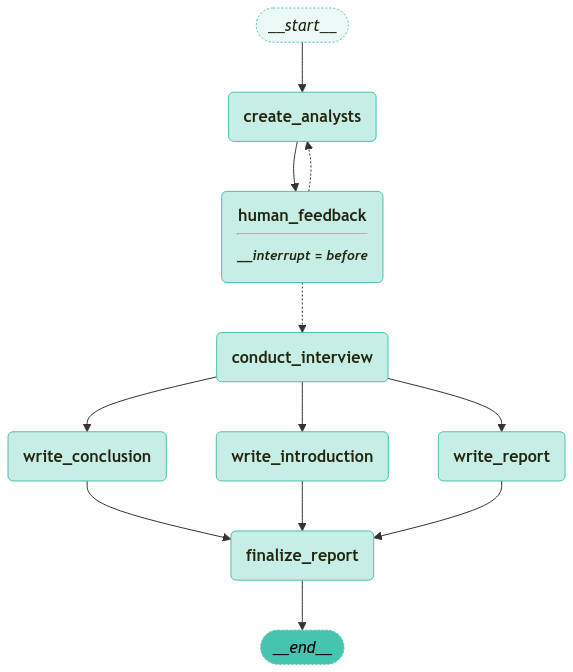

In [39]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langchain_opentutorial.graphs import visualize_graph

# Create graph
builder = StateGraph(ResearchGraphState)

# Define nodes
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# Define edges
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)

# Report generation from interviews
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# Final report assembly
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# Compile graph
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Visualize the workflow
visualize_graph(graph)

The graph structure implements:

**Core Workflow Stages**
- Analyst Creation
- Human Feedback Integration
- Parallel Interview Execution
- Report Generation
- Final Assembly

**Key Components**
- State Management using ResearchGraphState
- Memory persistence with MemorySaver
- Conditional routing based on human feedback
- Parallel processing of interviews
- Synchronized report assembly

**Flow Control**
- Starts with analyst creation
- Allows for human feedback and iteration
- Conducts parallel interviews
- Generates report components simultaneously
- Assembles final report with all components

This implementation creates a robust workflow for automated research with human oversight and parallel processing capabilities.

### Executing the Report Writing  Graph

 Here's how to run the graph with the specified parameters: 

In [40]:
# Set input parameters
max_analysts = 3
topic = "Explain how Modular RAG differs from traditional Naive RAG and the benefits of using it at the production level."

# Configure execution settings
config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

# Prepare input data
inputs = {"topic": topic, "max_analysts": max_analysts}

# Execute graph until first breakpoint
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Tech University' name='Dr. Emily Chen' role='AI Researcher' description='Dr. Chen focuses on the theoretical underpinnings of Modular and Naive RAGs. She is interested in the scalability and flexibility of Modular RAGs compared to traditional methods, with a focus on how these differences impact real-world applications.'
affiliation='Data Solutions Corp' name='Raj Patel' role='Industry Expert' description='Raj Patel is a seasoned industry expert who provides insights into the practical benefits of implementing Modular RAG in production environments. His focus is on cost-efficiency, performance improvements, and integration challenges compared to Naive RAG systems.'
affiliation='AI Ethics Council' name='Sofia Martinez' role='Ethicist' description='Sofia Martinez examines the ethical implications and societal impacts of deploying Modular RAG systems. Her work emphasizes the importance of transparen

Let's add `human_feedback` to customize the analyst team and continue the graph execution:

In [41]:
# Add new analyst with human feedback
graph.update_state(
    config,
    {"human_analyst_feedback": "Add Prof. Jeffrey Hinton as a head of AI analyst"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '4e5b3dcb-b241-4d1e-b32b-4911b4afde31',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9c7b-89f6-6c47-8002-703349137f1e'}}

In [42]:
# Continue graph execution
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='University of Toronto' name='Prof. Jeffrey Hinton' role='Head of AI Analyst' description='As a pioneer in the field of artificial intelligence, Prof. Hinton focuses on the theoretical underpinnings of AI systems, with a particular interest in how modular RAG can improve the scalability and efficiency of AI models in production environments. His concerns revolve around the sustainability and adaptability of AI systems in real-world applications.'
affiliation='Stanford University' name='Dr. Alice Nguyen' role='AI Systems Analyst' description='Dr. Nguyen specializes in the architecture and design of AI systems, focusing on the structural differences between Modular RAG and traditional Naive RAG. She is particularly interested in the modularity aspect and how it enhances system flexibility and maintenance at a production level.'
affiliation='Massachusetts Institute of Technology' name='Dr. Rahul Meht

Let's complete the human feedback phase and resume the graph execution: 

In [43]:
# End human feedback phase
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '4e5b3dcb-b241-4d1e-b32b-4911b4afde31',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9c7b-b98c-68ab-8004-83aa6162d821'}}

In [44]:
# Resume graph execution
invoke_graph(graph, None, config)


🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello, my name is Alex Carter, and I am an AI research journalist. Thank you for taking the time to speak with me, Prof. Hinton. To start, could you explain how Modular RAG differs from traditional Naive RAG in the context of AI systems? What are the core distinctions that make Modular RAG more suitable for production environments?

🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello Dr. Mehta, my name is Alex Carter, and I'm an analyst delving into the practical applications of AI. I am particularly interested in understanding how Modular RAG differs from traditional Naive RAG and the benefits it brings when deployed at the production level. Could you explain these differences 

Here's how to display the final research report: 

In [45]:
from IPython.display import Markdown

# Get final graph state
final_state = graph.get_state(config)

# Retrieve final report
report = final_state.values.get("final_report")

# Display report in markdown format
display(Markdown(report))

# Modular RAG: A Paradigm Shift in AI System Design

## Introduction

In an era where the demand for scalable, efficient, and adaptable artificial intelligence (AI) systems continues to rise, Modular Retrieval-Augmented Generation (RAG) systems are emerging as a transformative solution. The landscape of AI, particularly with the evolution of large language models (LLMs), is rapidly advancing, necessitating novel approaches to overcome the limitations of traditional systems. This report delves into the significant advancements brought by Modular RAG, contrasting it with Naive RAG systems and exploring its benefits at the production level.

We begin by examining the foundational role of Naive RAG systems, which integrate document retrieval with language generation but often falter due to their inflexibility and inefficiency in handling diverse datasets. Advanced RAG techniques address these challenges by leveraging dynamic embeddings and vector databases, enhancing semantic understanding and retrieval accuracy.

The heart of our analysis lies in the introduction of Modular RAG frameworks, which decompose complex RAG systems into independent modules. This modularity allows for reconfigurable designs, improving scalability and facilitating the integration of advanced technologies such as routing and scheduling mechanisms. We also explore the FlashRAG toolkit, a modular resource that standardizes RAG research, and the integration of graph-based systems to enhance knowledge-based tasks.

Lastly, we discuss the practical implications and challenges of deploying Modular RAG at scale, highlighting its potential to revolutionize AI applications across various domains. Through this exploration, we aim to illustrate how Modular RAG aligns with the vision of sustainable and adaptable AI systems, paving the way for future innovations.

---

## Main Idea



### Background

The emergence of Retrieval-Augmented Generation (RAG) systems has significantly influenced the development of AI, particularly in enhancing the capabilities of large language models (LLMs) for handling complex, knowledge-intensive tasks. Initially, RAG systems were exemplified by Naive RAG, which combined document retrieval with language generation to provide contextually relevant responses. However, these systems often struggled with dynamic datasets and specific semantic requirements, leading to inefficiencies and challenges in scalability [1][2]. The evolution of RAG into Modular RAG represents a groundbreaking shift, introducing a framework that decomposes RAG systems into flexible and independent modules. This modularity is key to enhancing scalability and adaptability, aligning with the vision of sustainable AI systems that can efficiently evolve in production environments [3][4]. The development of toolkits like FlashRAG further supports this evolution by offering a standardized platform for implementing and comparing RAG methods, thereby facilitating research and practical deployment [5].

### Related Work

Prior studies laid the groundwork for RAG systems, with Naive RAG establishing the foundational integration of retrieval and generation. These early models demonstrated the potential of AI systems to draw on external information sources, yet they faced notable limitations, including inflexibility and inefficiency in processing diverse datasets [1]. Advanced RAG models addressed some of these challenges by employing dynamic embedding techniques and vector databases, which improved the semantic understanding and adaptability of the systems [2]. The introduction of graph-based RAG systems further enhanced these capabilities by leveraging graph structures for more accurate information retrieval and generation [5]. The transition to Modular RAG builds on these advancements by offering a reconfigurable framework that supports various RAG patterns, such as linear, conditional, branching, and looping, each with its specific implementation nuances [4].

### Problem Definition

The primary challenge addressed by this research is the limitations of traditional Naive RAG systems in adapting to diverse and dynamic datasets. Specifically, these systems struggle with inflexibility, inefficiency, and a lack of semantic relevance, which impact their scalability and effectiveness in real-world applications [1][2][3]. The research aims to explore how Modular RAG can overcome these limitations by providing a flexible and scalable architecture that supports the evolving demands of AI systems. This involves developing modular frameworks that decompose complex RAG systems into independent modules, allowing for more efficient design and maintenance [4][5]. Additionally, the research seeks to address practical challenges related to data management and integration, ensuring that Modular RAG systems can be effectively deployed at the production level [6][7].

### Methodology

Modular RAG systems are designed by breaking down traditional RAG processes into independent modules and specialized operators, facilitating greater flexibility and adaptability. This approach enables the integration of advanced design features such as routing, scheduling, and fusion mechanisms, which are crucial for handling complex application scenarios [3][4]. The methodology involves implementing various RAG patterns—linear, conditional, branching, and looping—each with its specific nuances, allowing for tailored solutions to specific task requirements [4][5]. The comprehensive framework provided by toolkits like FlashRAG supports the reproduction of existing RAG methods and the development of new algorithms, ensuring consistency and facilitating comparative studies among researchers [5]. Additionally, theoretical frameworks are explored to understand the trade-offs between the benefits and detriments of retrieved texts, offering a structured approach to optimizing RAG performance [4].

### Implementation Details

The practical implementation of Modular RAG involves utilizing software frameworks and computational resources that support modular architecture. FlashRAG, a modular toolkit, provides a standardized platform for implementing and comparing RAG methods, offering a customizable environment for researchers to develop and test RAG algorithms [5]. The toolkit includes 12 advanced RAG methods and 32 benchmark datasets, enabling researchers to optimize their RAG processes and ensuring consistency in evaluations [3][5]. Additionally, the use of vector databases and dynamic embedding techniques enhances the retrieval and generation processes, making them more context-aware and accurate [2]. The modular architecture also supports end-to-end training across its components, marking a significant advancement over traditional RAG systems [3].

### Experiments

Experimental protocols for Modular RAG systems involve evaluating their performance across various application scenarios and datasets. The use of comprehensive toolkits like FlashRAG facilitates the implementation of standardized evaluation metrics and procedures, ensuring consistency in testing and comparison [5]. Experiments focus on assessing the scalability, adaptability, and efficiency of Modular RAG systems, particularly in handling diverse and dynamic datasets. Evaluation metrics include measures of retrieval accuracy, response coherence, and system scalability. Additionally, experiments explore the integration of fair ranking mechanisms to ensure equitable exposure of relevant items, thereby promoting fairness and reducing potential biases in RAG systems [3]. Theoretical studies further support experimental findings by modeling the trade-offs between the benefits and detriments of retrieved texts, offering insights into optimizing RAG performance [4].

### Results

The results of implementing Modular RAG systems demonstrate significant improvements in flexibility, scalability, and efficiency compared to traditional Naive RAG models. Modular RAG's reconfigurable design allows for seamless integration and optimization of independent modules, resulting in enhanced adaptability to diverse application scenarios [4][5]. The use of dynamic embeddings and vector databases further improves retrieval accuracy and context-awareness, making Modular RAG systems more effective for knowledge-intensive applications [2]. The incorporation of graph-based approaches enhances real-time data integration and contextual understanding, addressing limitations related to static knowledge bases [5]. Moreover, the integration of fair ranking mechanisms ensures equitable exposure of relevant items, promoting fairness and reducing biases [3]. Overall, Modular RAG presents a compelling evolution in AI system design, offering a more adaptable and efficient framework for deploying AI solutions at scale.

### Sources

[1] https://www.superteams.ai/blog/how-to-implement-naive-rag-advanced-rag-and-modular-rag  
[2] https://zilliz.com/blog/advancing-llms-native-advanced-modular-rag-approaches  
[3] http://arxiv.org/abs/2407.21059v1  
[4] http://arxiv.org/abs/2406.00944v2  
[5] http://arxiv.org/abs/2405.13576v1  
[6] https://medium.com/aingineer/a-comprehensive-guide-to-implementing-modular-rag-for-scalable-ai-systems-3fb47c46dc8e  
[7] https://medium.com/@sahin.samia/modular-rag-using-llms-what-is-it-and-how-does-it-work-d482ebb3d372

---

## Conclusion

The evolution from Naive to Modular Retrieval-Augmented Generation (RAG) systems represents a significant leap forward in the scalability and adaptability of artificial intelligence. Naive RAG laid the initial groundwork by integrating document retrieval with language generation, but its limitations in handling dynamic datasets and inflexibility necessitated advancements. Advanced RAG techniques addressed these issues by employing dynamic embeddings and vector databases, enhancing semantic understanding and adaptability.

Modular RAG frameworks mark a transformative advancement by decomposing complex systems into independent modules, allowing for a reconfigurable and scalable architecture. This modularity not only supports diverse RAG patterns, such as linear, conditional, branching, and looping, but also facilitates the integration of advanced technologies like routing and scheduling mechanisms. Toolkits like FlashRAG further standardize RAG research, offering a comprehensive environment for algorithm development and comparison.

Graph-based RAG systems and theoretical insights into benefit-detriment trade-offs provide additional layers of sophistication, improving real-time data integration and contextual understanding. However, challenges persist, particularly in data management and ensuring fair ranking.

Overall, Modular RAG aligns with the vision of creating sustainable and adaptable AI systems, promising significant benefits in production environments. Continued research and innovation in this field are essential to fully realizing its potential and overcoming existing challenges.

In [46]:
print(report)

# Modular RAG: A Paradigm Shift in AI System Design

## Introduction

In an era where the demand for scalable, efficient, and adaptable artificial intelligence (AI) systems continues to rise, Modular Retrieval-Augmented Generation (RAG) systems are emerging as a transformative solution. The landscape of AI, particularly with the evolution of large language models (LLMs), is rapidly advancing, necessitating novel approaches to overcome the limitations of traditional systems. This report delves into the significant advancements brought by Modular RAG, contrasting it with Naive RAG systems and exploring its benefits at the production level.

We begin by examining the foundational role of Naive RAG systems, which integrate document retrieval with language generation but often falter due to their inflexibility and inefficiency in handling diverse datasets. Advanced RAG techniques address these challenges by leveraging dynamic embeddings and vector databases, enhancing semantic understanding